In [1]:
from credo_cf import load_json, progress_and_process_image, group_by_id

objects, count, errors = load_json('../data/manual.json', progress_and_process_image)
by_id = group_by_id(objects)

def display(img):
    plt.matshow(img)
    plt.colorbar()
    plt.show()

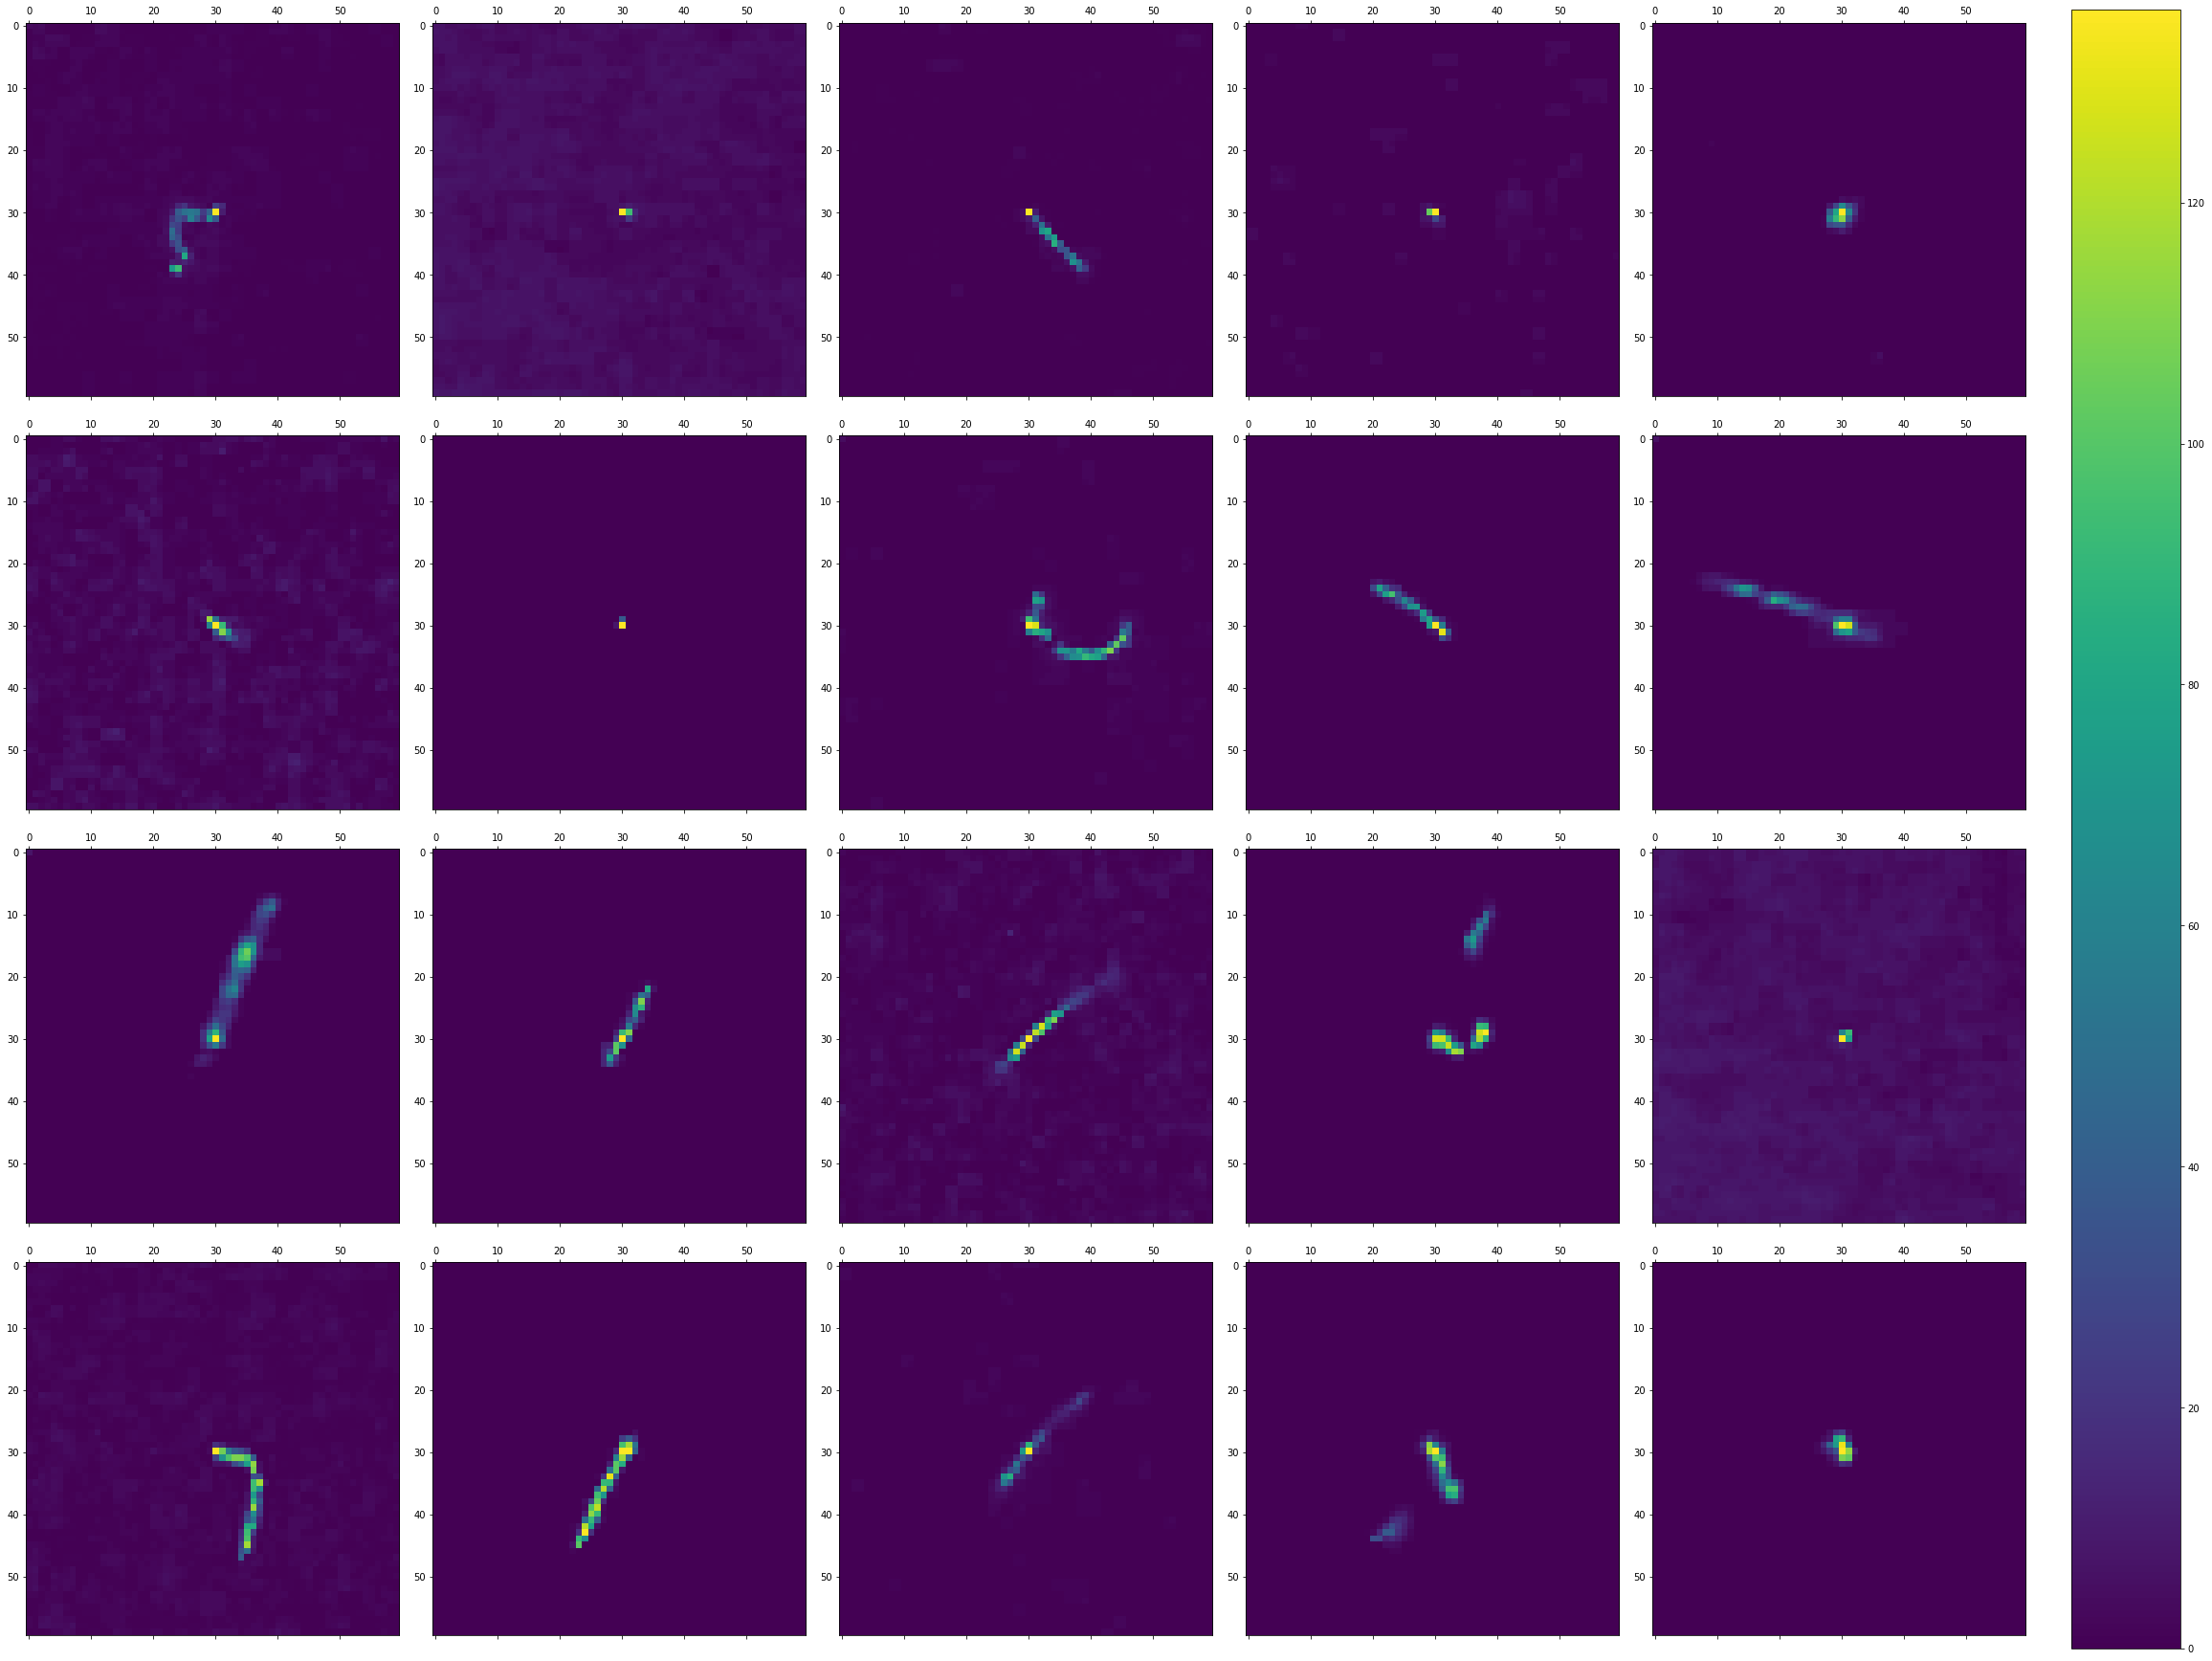

In [2]:
import matplotlib.pyplot as plt

used_hits = {4711435, 6234182, 9152349, 4913621, 5468291, 7097636, 4976474, 5206452, 4876475, 5951007, 4714801, 4819239, 4660572, 4705446, 8280225, 8459656, 8471578, 9124308, 9314789, 4813841}
hits = []
for u in used_hits:
    hits.append(by_id[u][0])

    
def display_all(values):
    f, axs=plt.subplots(4, 5, constrained_layout=True, figsize=(32, 24))
    i = 0
    for ax in axs.flat:
        im = ax.matshow(values[i])
        i += 1
    f.colorbar(im, ax=axs.flat)
    plt.show()

            
vs = list(map(lambda x: x['gray'], hits))
display_all(vs)


Image: 1
[{'core': (30, 30), 'value': 179}, {'core': (39, 24), 'value': 122}, {'core': (37, 25), 'value': 107}, {'core': (31, 26), 'value': 77}, {'core': (33, 23), 'value': 63}]

Image: 2
[{'core': (30, 30), 'value': 128}]

Image: 3
[{'core': (30, 30), 'value': 150}, {'core': (35, 34), 'value': 99}, {'core': (33, 33), 'value': 93}, {'core': (38, 37), 'value': 81}]

Image: 4
[{'core': (30, 30), 'value': 85}]

Image: 5
[{'core': (30, 30), 'value': 92}]

Image: 6
[{'core': (30, 30), 'value': 103}]

Image: 7
[{'core': (30, 30), 'value': 67}]

Image: 8
[{'core': (30, 30), 'value': 126}, {'core': (34, 43), 'value': 101}, {'core': (32, 45), 'value': 95}, {'core': (35, 39), 'value': 84}, {'core': (26, 31), 'value': 72}, {'core': (34, 36), 'value': 65}]

Image: 9
[{'core': (30, 30), 'value': 78}, {'core': (25, 23), 'value': 55}, {'core': (24, 21), 'value': 45}]

Image: 10
[{'core': (30, 30), 'value': 102}, {'core': (26, 19), 'value': 68}, {'core': (24, 14), 'value': 59}, {'core': (27, 23), 'va

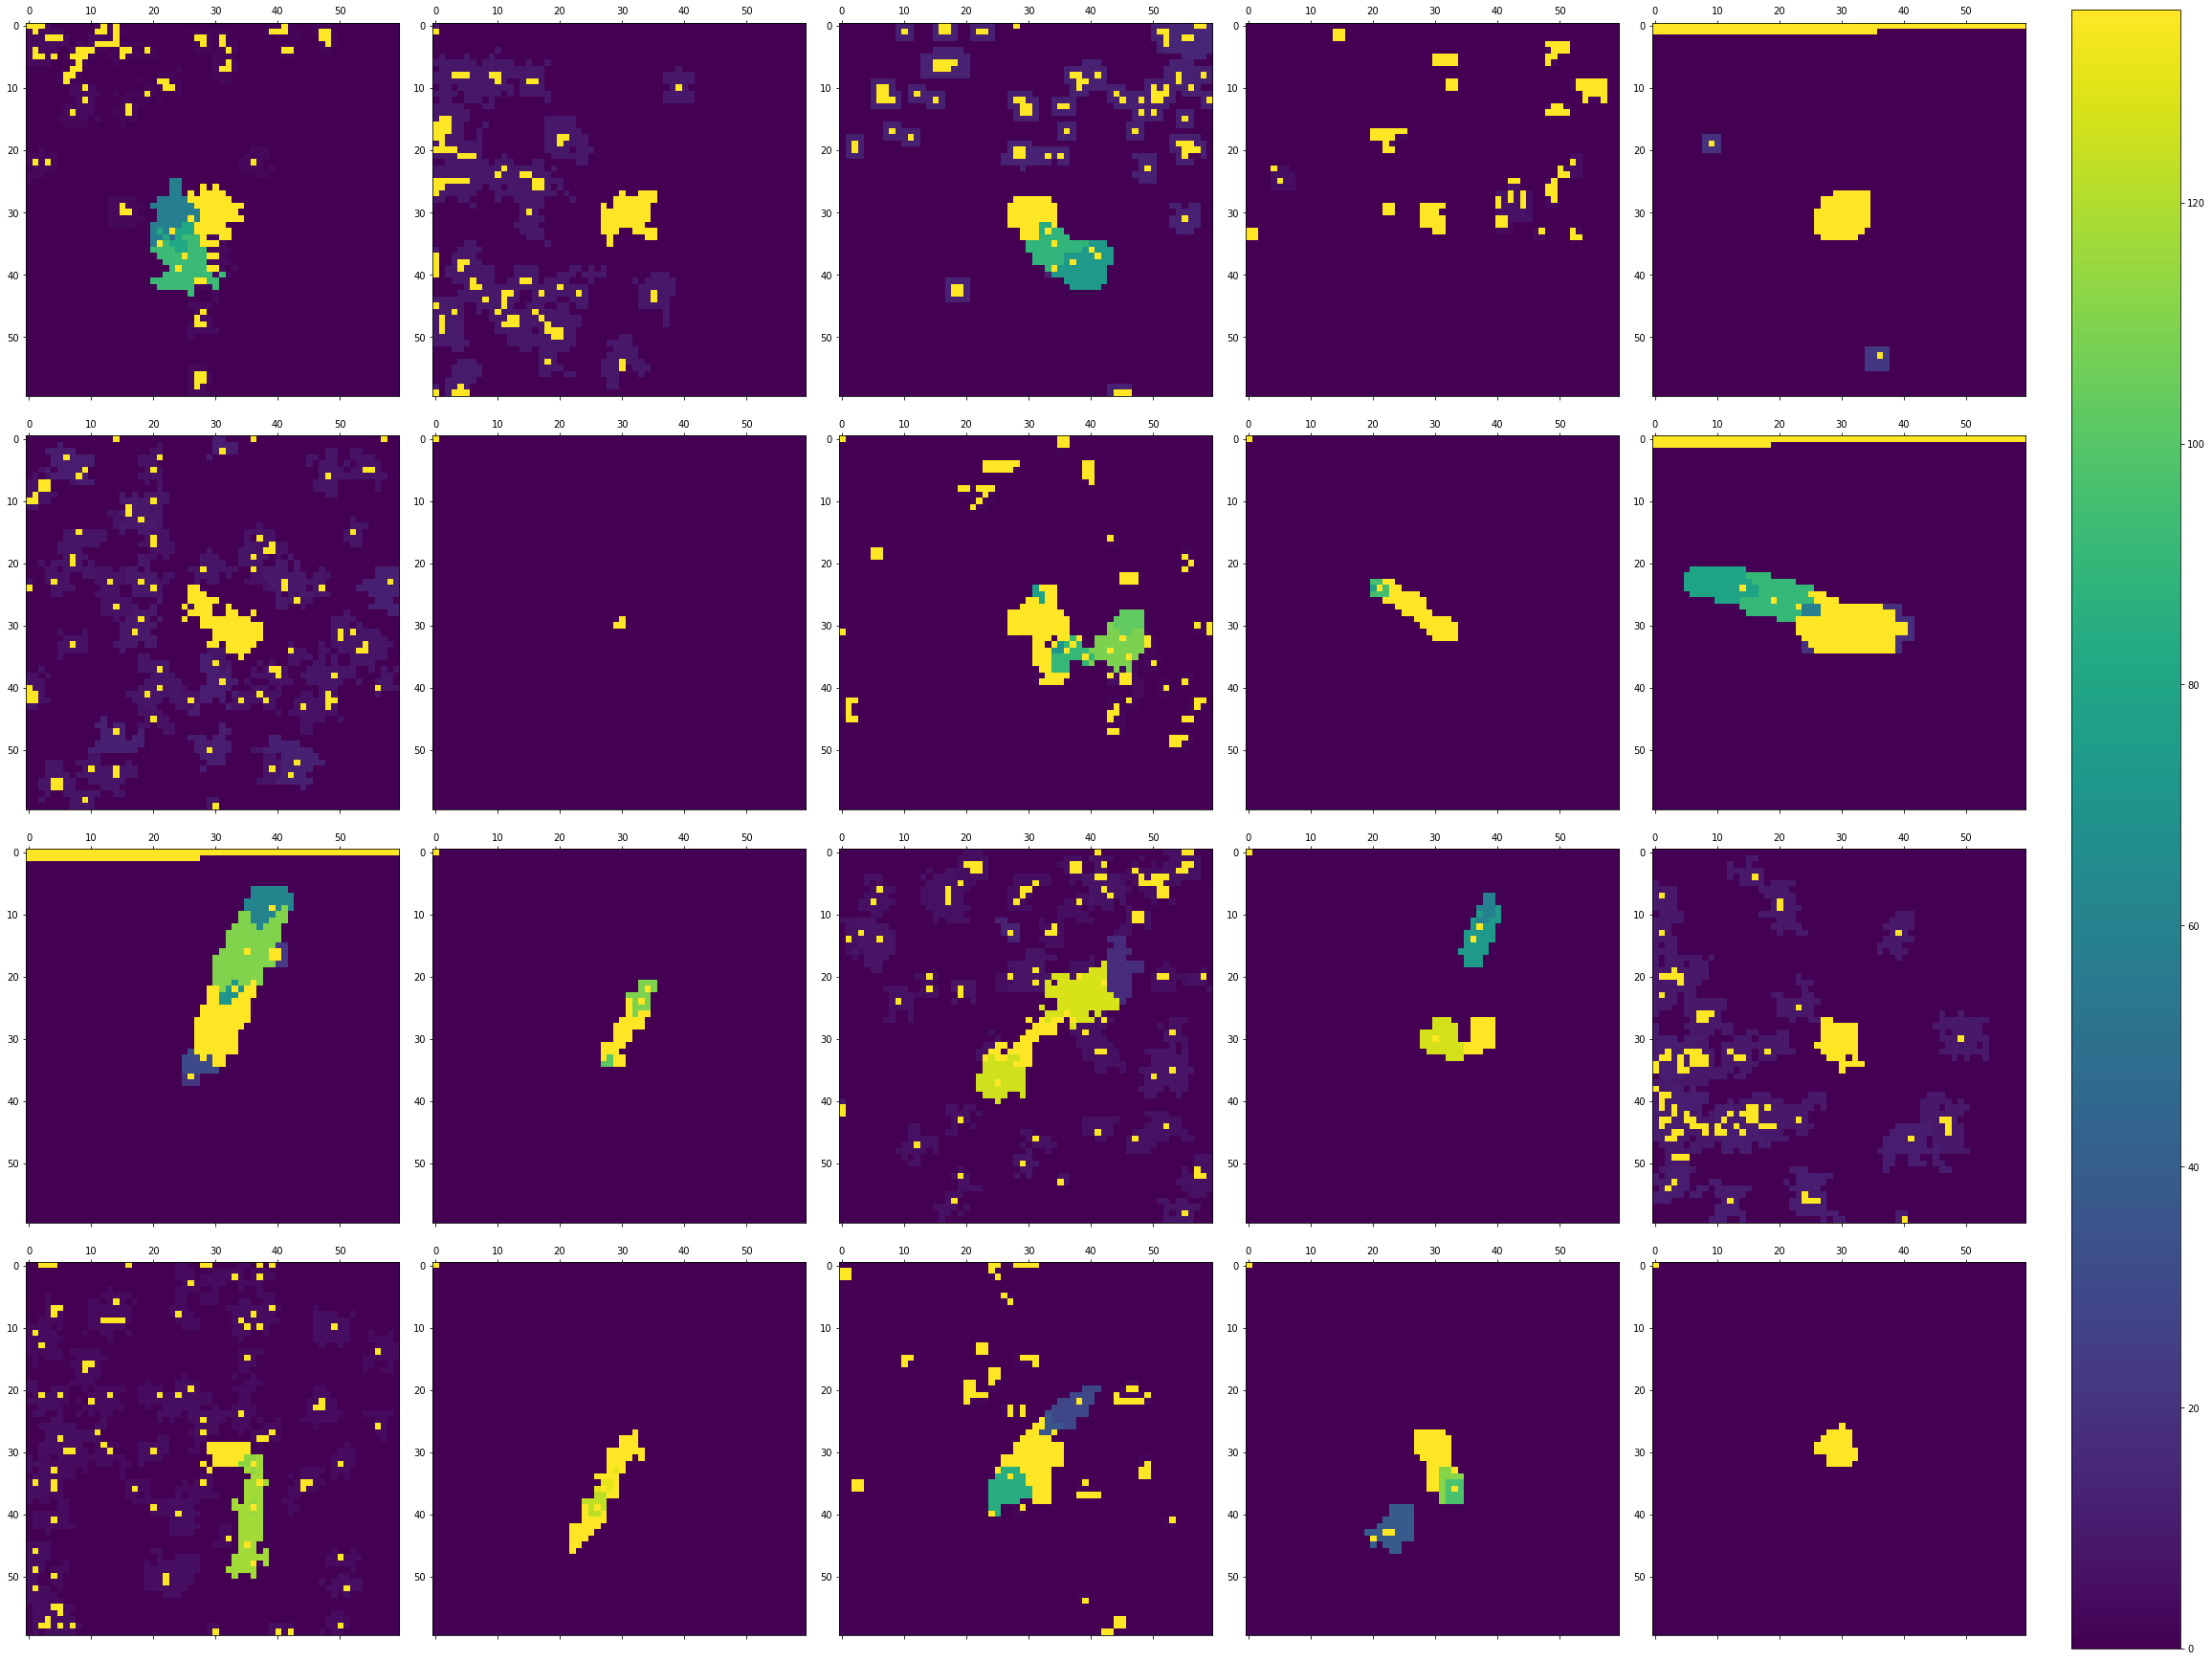

Threshold


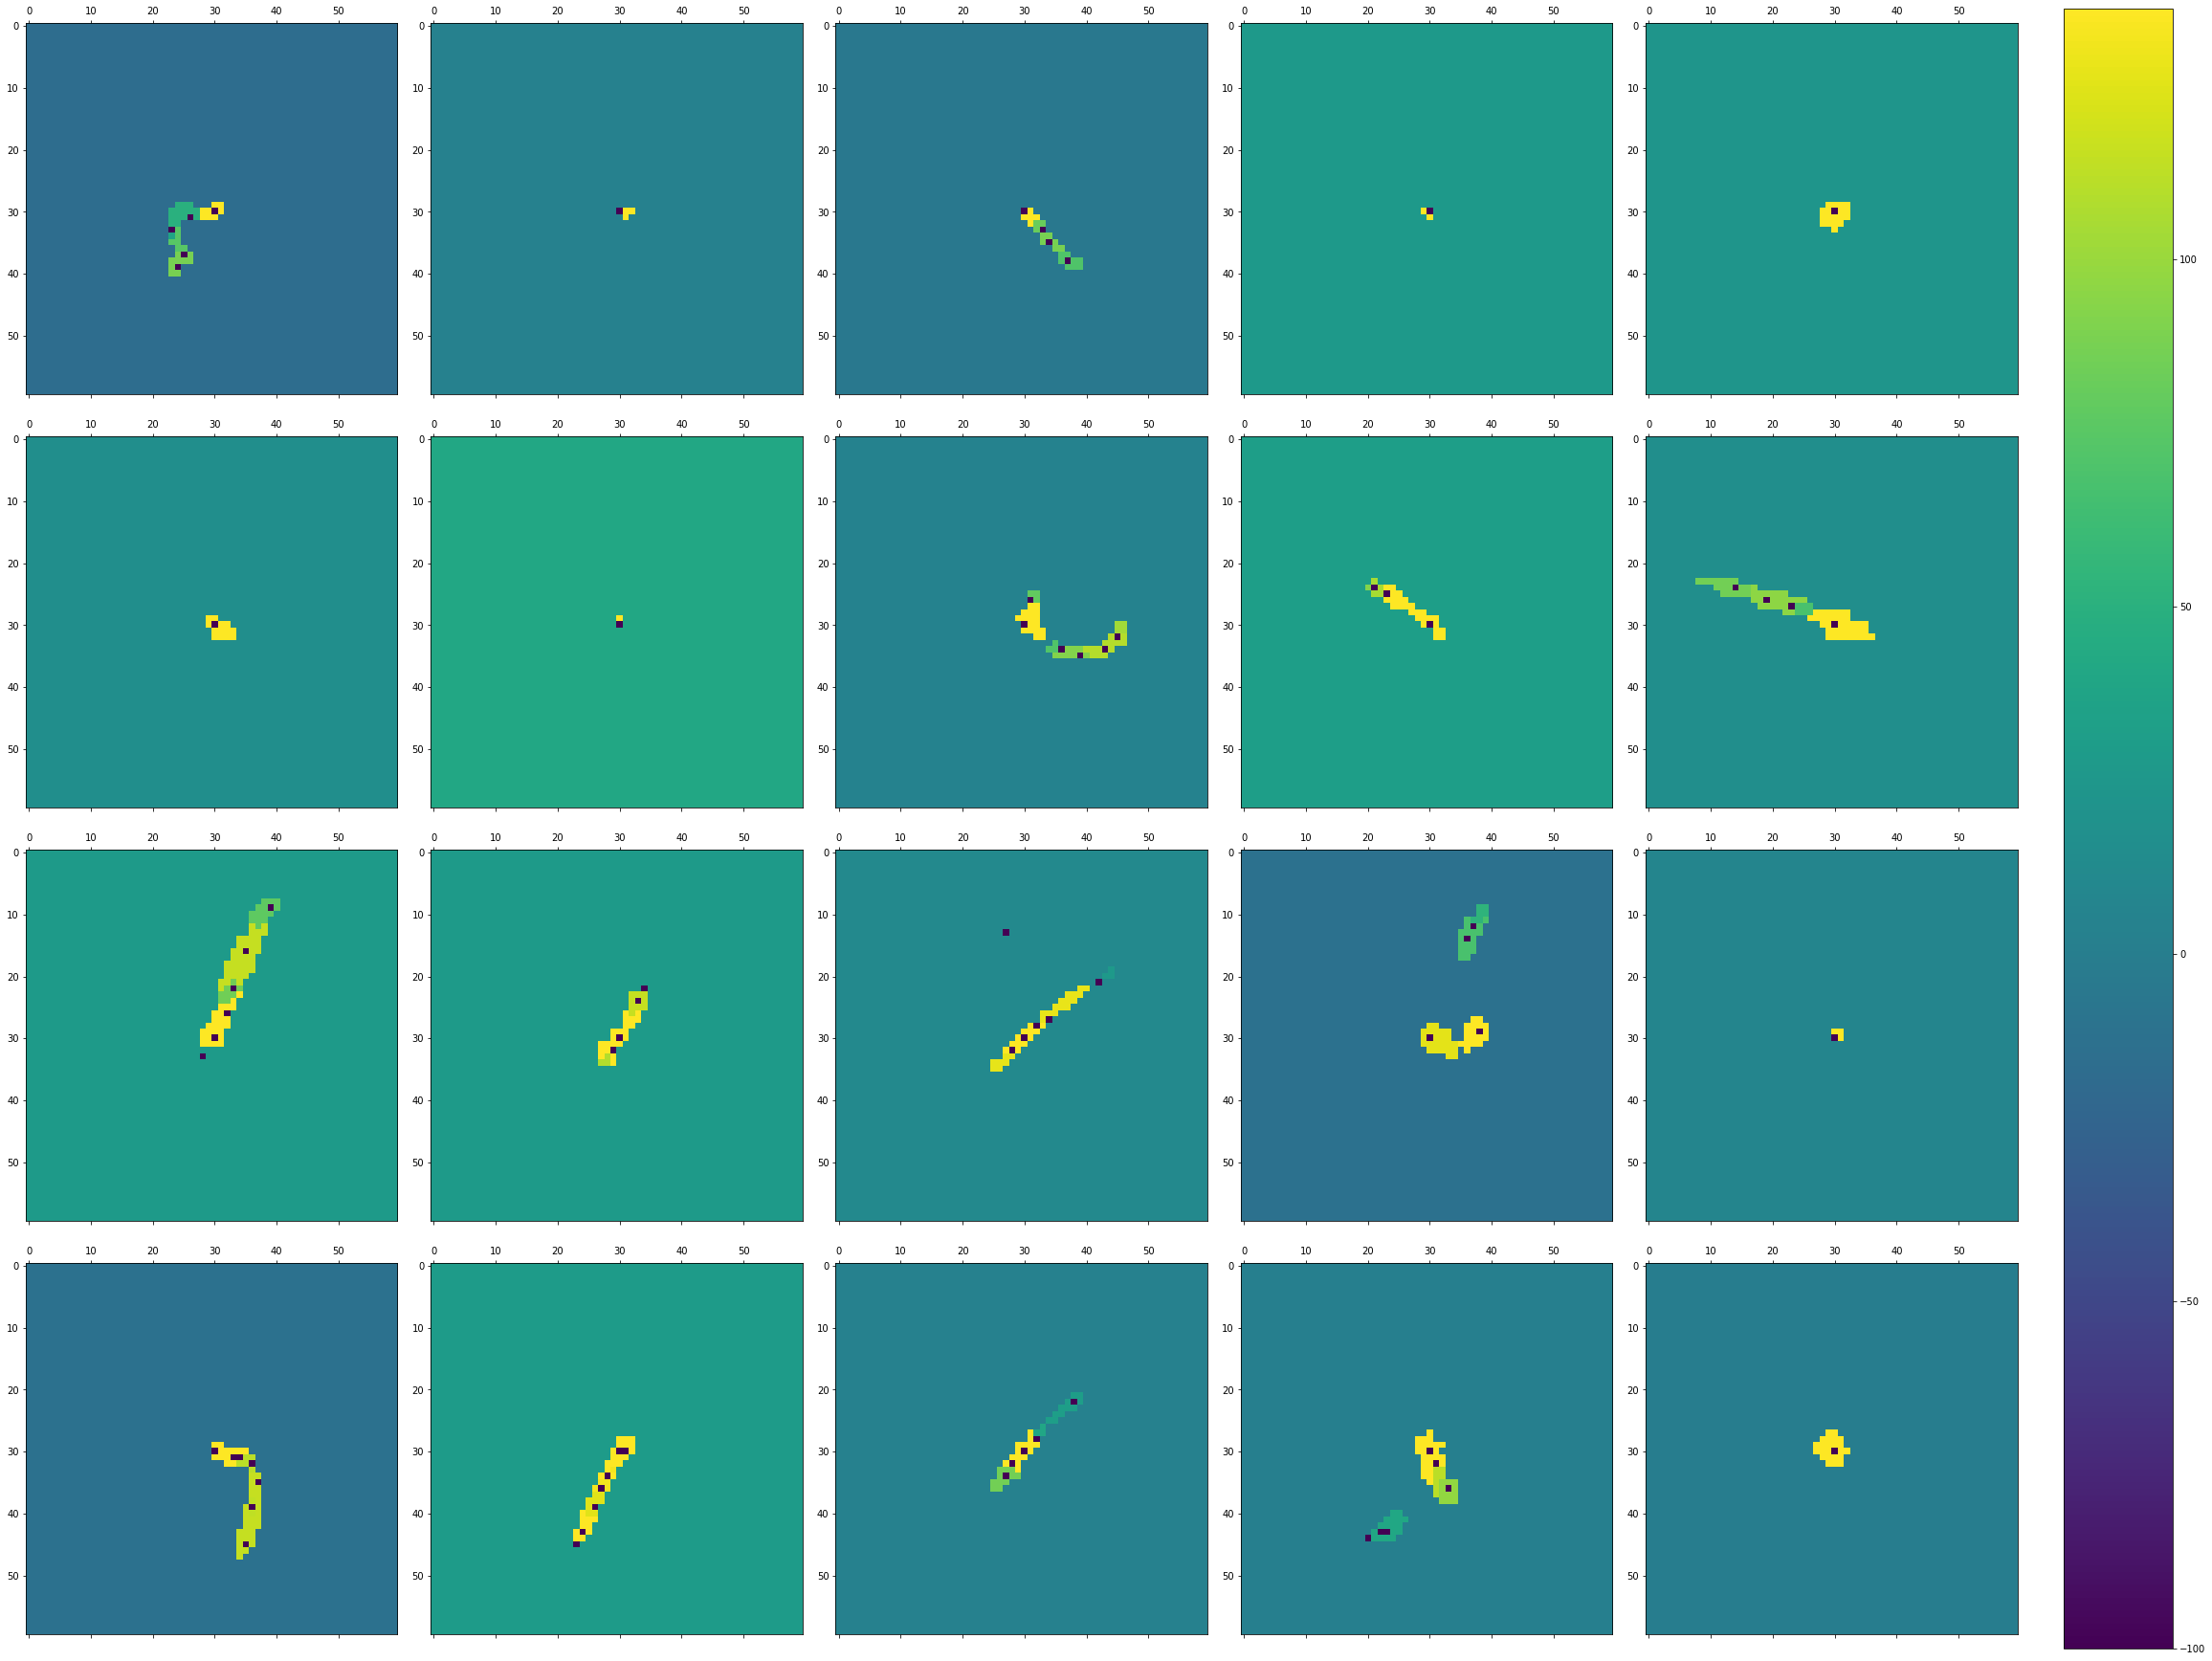

In [30]:
from numpy import unravel_index
import numpy as np

used_kernel = [
    [-1, 0],
    [0, -1],
    [1, 0],
    [0, 1]
]

used_kernel2 = [
    [-1, 0],
    [-1, -1],
    [0, -1],
    [1, -1],
    [1, 0],
    [1, 1],
    [0, 1],
    [-1, 1]
]

def requrence_mark(inp, mark, color, point, kernel, threshold):
    cv = inp[point]
    mark[point] = color
    inp[point] = 0
    for k in kernel:
        try:
            p2 = (point[0] + k[0], point[1] + k[1])
            if p2[0] < 0 or p2[1] < 0 or p2[0] >= np.size(inp, 0) or p2[1] >= np.size(inp, 1):
                return
            
            cv2 = inp[p2]
            m2 = mark[p2]
            if m2 == 0 and cv2 < cv and cv2 > threshold:
                requrence_mark(inp, mark, color, p2, kernel, threshold)
        except IndexError:
            pass
    
    
def requrence_mark2(inp, mark, color, point, kernel, threshold):
    cv = inp[point]
    mark[point] = color
    inp[point] = 0
    nexts = []
    
    for k in kernel:
        try:
            p2 = (point[0] + k[0], point[1] + k[1])
            if p2[0] < 0 or p2[1] < 0 or p2[0] >= np.size(inp, 0) or p2[1] >= np.size(inp, 1):
                return
            
            cv2 = inp[p2]
            m2 = mark[p2]
            
            if m2 == 0 and cv2 < cv and cv2 > threshold:
                mark[p2] = color
                # inp[p2] = 0
                nexts.append((inp, mark, color, p2, kernel, threshold))
        except IndexError:
            pass
        
    for n in nexts:
        try:
            requrence_mark2(*n)
        except IndexError:
            pass
    
    
def mark_all(imgs, kernel, requrence):
    maps1 = []
    maps2 = []
    img_pos = 0
    
    for hit in imgs:
        img_pos += 1
        
        a = hit.copy()
        b = np.zeros(a.shape)
        cores = []
        
        find_median = []
        
        for i in range(1, 100):
            core = unravel_index(a.argmax(), a.shape)
            core_value = a[core]
            cores.append(core_value)
            find_median.append(core_value)
            requrence(a, b, core_value, core, kernel, 0)
            b[core] = cores[0]
            
        maps1.append(b)

        core_median = find_median[len(find_median) // 2]
        #threshold = (find_median[0] - core_median) // 10 + core_median
        threshold = core_median + 5
        
        found_cores = []

        a = hit.copy()
        b = np.zeros(a.shape)
        while True:
            core = unravel_index(a.argmax(), a.shape)
            core_value = a[core]
            if core_value <= threshold:
                break
                
            cores.append(core_value)
            found_cores.append({'core': core, 'value':core_value})
            requrence(a, b, core_value, core, kernel, threshold)
            b[core] = -100
        
        maps2.append(b)
        print('\nImage: %d' % img_pos)
        print(found_cores)
        
    display_all(maps1)
    print('Threshold')
    display_all(maps2)
    
#mark_all(vs, used_kernel, requrence_mark)
mark_all(vs, used_kernel2, requrence_mark2)